In [2]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import pyabc
from pyabc.plots import plot_marginals, plot_particles
%matplotlib notebook

<IPython.core.display.Javascript object>


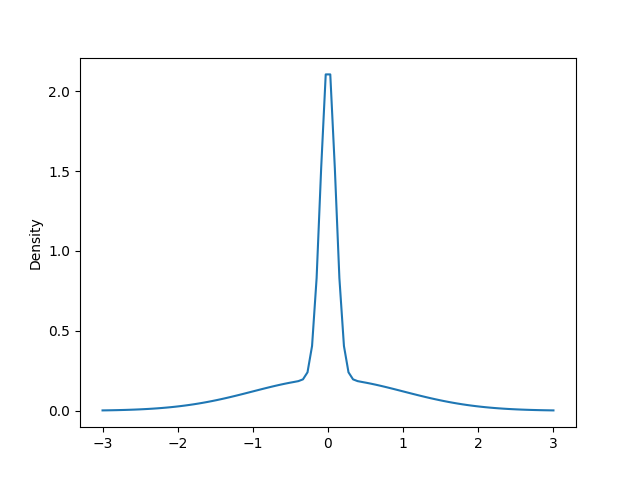

In [5]:
prior = pyabc.Prior('uniform', -10, 20, name='mu')
prior.sample()

def simulator(mu):
    return np.random.normal(mu, 1, size=100)

summary = lambda x: x
    
def rho(y, x):
    if np.random.rand() < 0.5:
        #print(np.abs(x.mean()))
        rho = np.abs(x.mean())
    else:
        #print(np.abs(x[0]))
        rho = np.abs(x[0])
    return rho
    
def posterior(mu):
    return 0.5 * ss.norm.pdf(mu, 0, 1) + 0.5 * ss.norm.pdf(mu, 0, np.sqrt(0.01))

y0 = np.array([0.])

x = np.linspace(-3, 3, 100)
plt.figure()
plt.plot(x, posterior(x))
plt.ylabel("Density")
plt.show()

In [7]:
rej = pyabc.RejectionSampler(priors=[prior], simulator=simulator, 
                             summaries=[summary], distance=rho,
                             observation=y0)

In [8]:
rej.sample(nr_samples=1000, threshold=0.025)

Rejection sampler started with threshold: 0.025 and number of samples: 1000
Samples:   1000 - Threshold: 0.0250 - Iterations:     393000 - Acceptance rate: 0.002545 - Time:     9.54 s


<IPython.core.display.Javascript object>


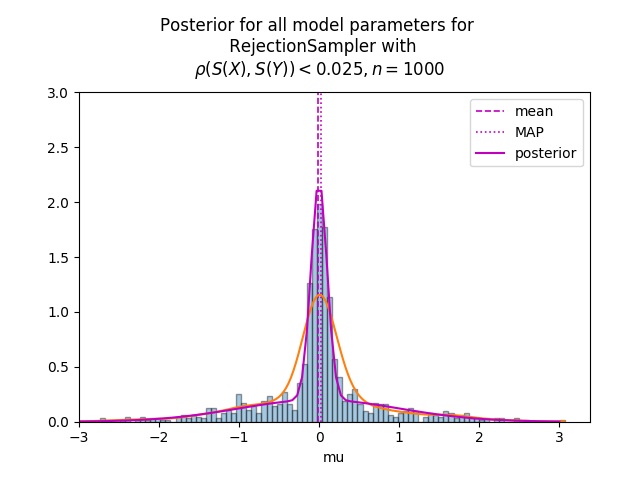

In [12]:
fig = plot_marginals(rej, xlim=(-3,3), ylim=(0,3))

x = np.linspace(-3,3, 100)
y = posterior(x)
plt.plot(x,y, "m", label="posterior")
plt.legend()
plt.show()

In [13]:
mcmc = pyabc.MCMCSampler(priors=[prior], simulator=simulator, 
                         summaries=[summary], distance=rho,
                         observation=y0)

In [14]:
mcmc.sample(nr_samples=10000, threshold=0.025, step_size=[0.15**2])

MCMC sampler started with threshold: 0.025 and number of samples: 10000
Samples:  10000 - Threshold: 0.0250 - Iterations:     242223 - Acceptance rate: 0.041284 - Time:    61.38 s


In [32]:
mcmc.sample(nr_samples=10000, threshold=0.025, step_size=[0.5**2])

MCMC sampler started with threshold: 0.025 and number of samples: 10000
Samples:  10000 - Threshold: 0.0250 - Iterations:     444802 - Acceptance rate: 0.022482 - Time:   106.97 s


<IPython.core.display.Javascript object>


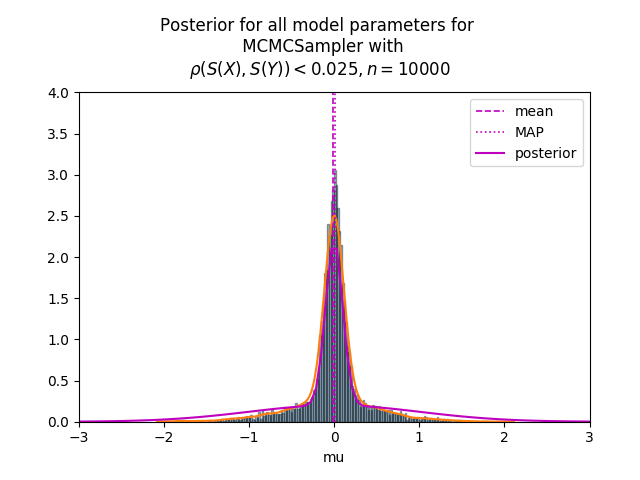

In [33]:
plot_marginals(mcmc, xlim=(-3,3), ylim=(0,4))

x = np.linspace(-3,3, 100)
y = posterior(x)
plt.plot(x,y, "m", label="posterior")
plt.legend()
plt.xlim(-3,3)
plt.show()

<IPython.core.display.Javascript object>


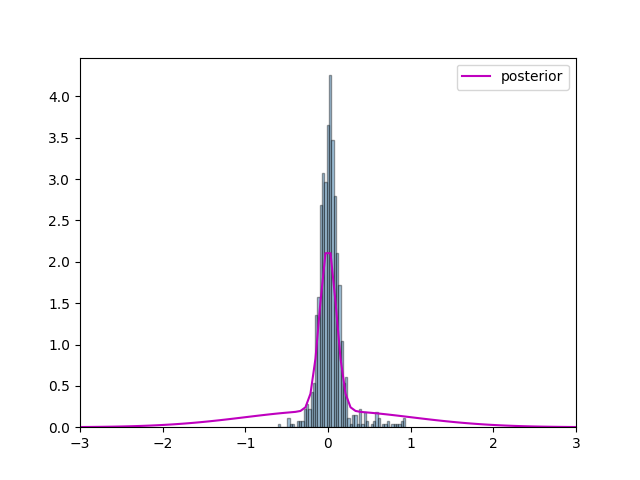

In [29]:
plt.figure()
plt.hist(mcmc.Thetas[-1000:], bins="auto", alpha=0.4, edgecolor="k", normed=True)
plt.xlim(-3,3)

x = np.linspace(-3,3, 100)
y = posterior(x)
plt.plot(x,y, "m", label="posterior")
plt.legend()
plt.xlim(-3,3)
plt.show()

In [34]:
smc = pyabc.SMCSampler(priors=[prior], simulator=simulator, 
                             summaries=[summary], distance=rho,
                             observation=y0)

In [37]:
smc.sample(nr_samples=1000, thresholds=np.linspace(2, 0.025, 6))

SMC sampler started with thresholds: [ 2.     1.605  1.21   0.815  0.42   0.025] and number of samples: 1000
Iteration 0 completed
starting iteration[ 1 ]
Iteration 1 completed
starting iteration[ 2 ]
Iteration 2 completed
starting iteration[ 3 ]
Iteration 3 completed
starting iteration[ 4 ]
Iteration 4 completed
starting iteration[ 5 ]
Iteration 5 completed
Samples:   1000 - Thresholds: 0.03 - Iterations:      93384 - Acceptance rate: 0.010708 - Time:    45.93 s


<IPython.core.display.Javascript object>


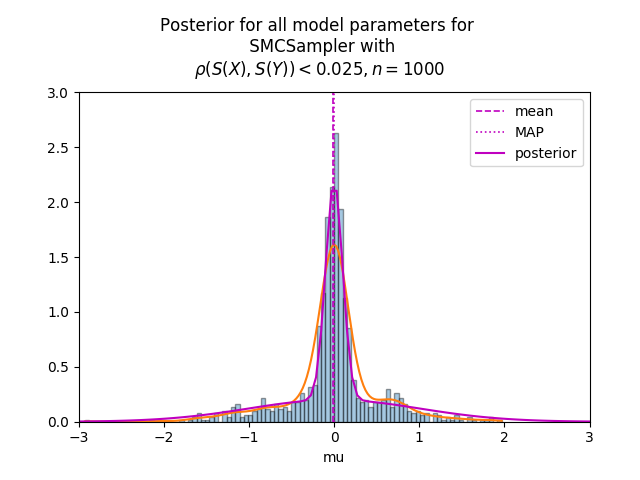

In [38]:
plot_marginals(smc, xlim=(-3,3), ylim=(0,3))

x = np.linspace(-3,3, 100)
y = posterior(x)
plt.plot(x,y, "m", label="posterior")
plt.legend()
plt.xlim(-3,3)
plt.show()

In [19]:
abcde = pyabc.ABCDESampler(
    priors=[prior],
    simulator=simulator,
    summaries=[summary],
    distance=rho,
    observation=y0,
    exp_lambda = 10
)

In [20]:
abcde.sample(nr_samples=450, nr_groups = 3, nr_iter = 300, burn_in = 200, alpha = 0.1, beta = 0.1, kappa = 0.9)

ABC-Differential-Evolution sampler started with number of samples: 450
initializing pools
starting iteration [ 100 ]
starting iteration [ 200 ]
Samples:    450 - Iterations:        300 - Acceptance rate: None - Time:   204.04 s


<IPython.core.display.Javascript object>


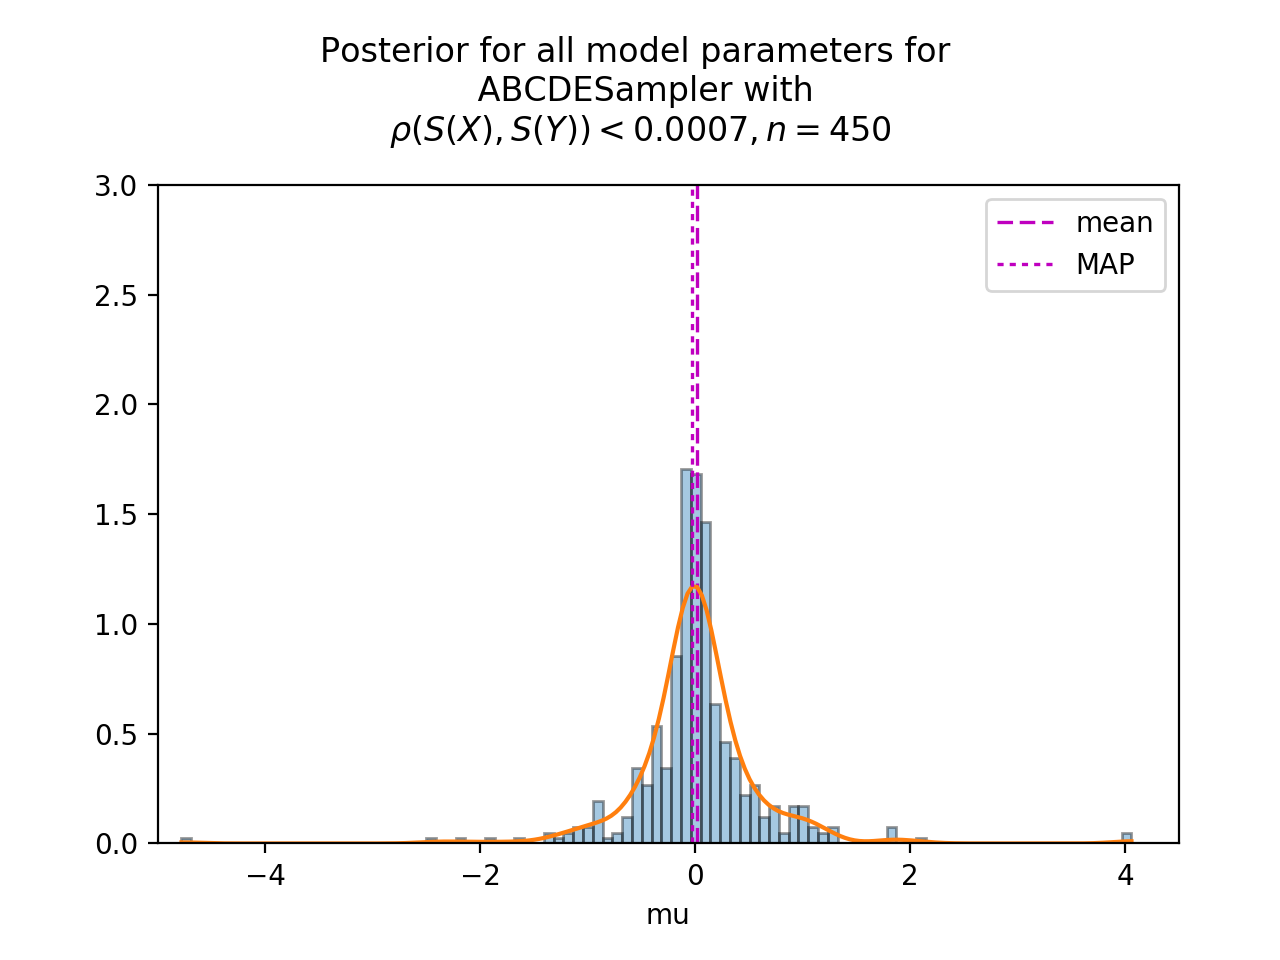

<IPython.core.display.Javascript object>


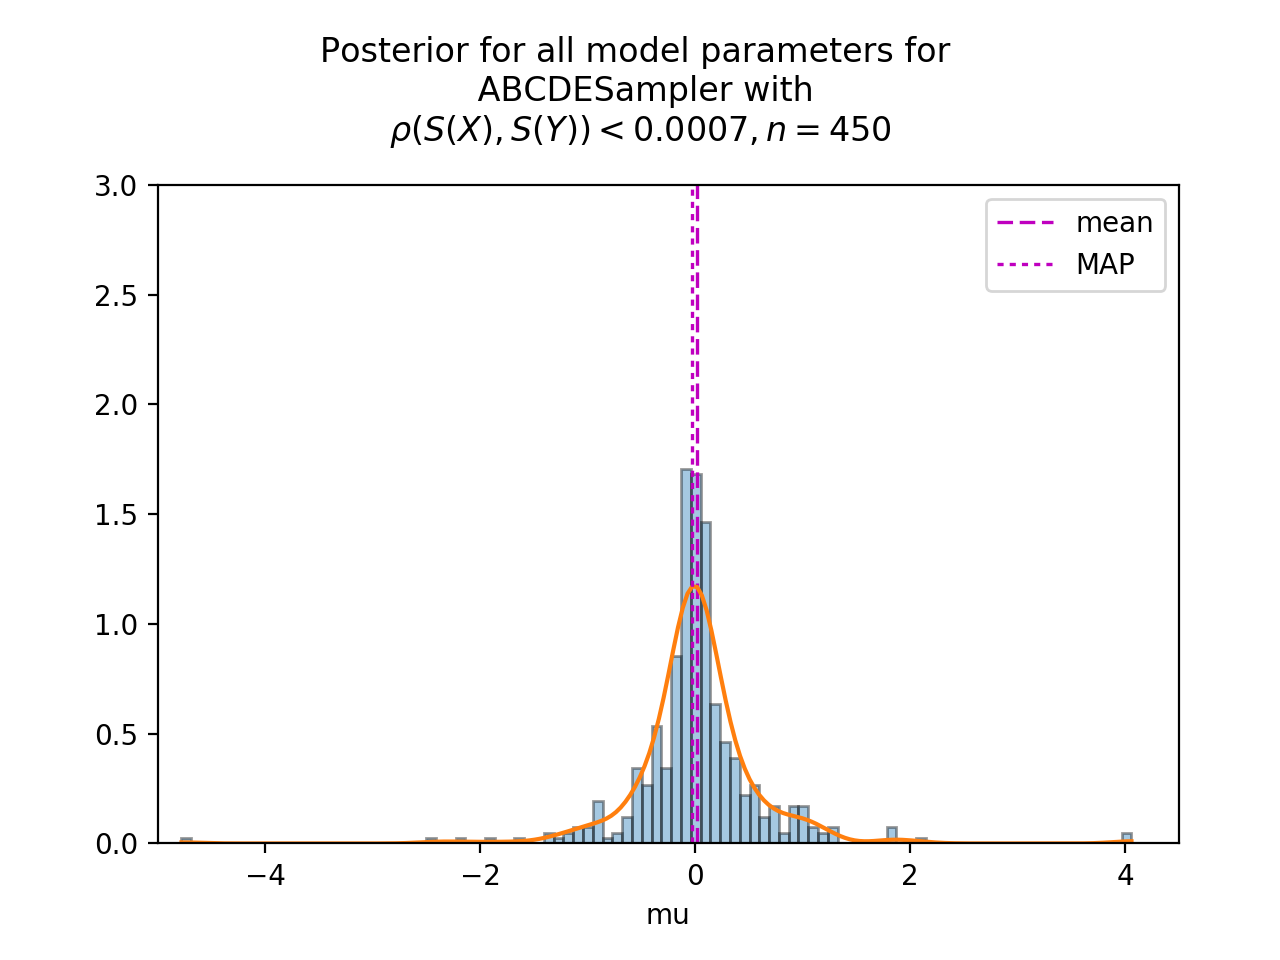

In [18]:
plot_marginals(abcde, xlim=(-5,5), ylim=(0,3))